In [59]:
import pandas as pd
import numpy as np
import os
import json
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt

In [61]:
NYC_df = pd.read_csv('data/NYC_trunc.csv',low_memory=False)
CHI_df = pd.read_csv('data/CHI_trunc.csv',low_memory=False)

In [63]:
NYC_df.head()

,date,mode,daily_ridership,mode_subway,rain_sum,rain_max,relative_humidity_2m_min,relative_humidity_2m_max,relative_humidity_2m_mean,apparent_temperature_min,...,us_aqi_max_bin_lag,us_aqi_max_lag,us_aqi_mean_bin,us_aqi_mean_bin_lag,us_aqi_mean_lag,is_weekend,is_holiday,is_holiday_adjacent,snow_any,snow_heavy
0,2023-01-01,bus,1138.528967,False,-0.055314,-0.044939,-0.005741,1.274998,0.875430,-0.149096,...,1.430683,0.961783,0.71944,0.717293,1.896281,1.0,1.0,1.0,0.0,0.0
1,2023-01-01,subway,3929.710280,True,-0.055314,-0.044939,-0.005741,1.274998,0.875430,-0.149096,...,1.430683,0.961783,0.71944,0.717293,1.896281,1.0,1.0,1.0,0.0,0.0
2,2023-01-02,bus,1803.312343,False,-0.303307,-0.238592,0.237532,0.228408,0.217885,-0.403263,...,0.050961,0.331006,0.71944,0.717293,0.700501,0.0,1.0,1.0,0.0,0.0
3,2023-01-02,subway,4581.294393,True,-0.303307,-0.238592,0.237532,0.228408,0.217885,-0.403263,...,0.050961,0.331006,0.71944,0.717293,0.700501,0.0,1.0,1.0,0.0,0.0
4,2023-01-03,bus,3074.851385,False,-0.258217,-0.168173,1.514716,1.274998,1.638075,-0.118282,...,0.050961,0.522851,2.53920,0.717293,0.438041,0.0,0.0,1.0,0.0,0.0


In [65]:
cols_to_keep = [
    'date', 
    'mode', 
    'daily_ridership',
    'us_aqi_mean',
    'us_aqi_pm2_5_mean',
    'us_aqi_pm10_mean',
    'us_aqi_nitrogen_dioxide_mean',
    'us_aqi_ozone_mean',
    'us_aqi_sulphur_dioxide_mean',
    'us_aqi_carbon_monoxide_mean',
    'apparent_temperature_max',
    'apparent_temperature_min',
    'apparent_temperature_max_lag',
    'apparent_temperature_min_lag',
    'relative_humidity_2m_mean',
    'rain_sum',
    'rain_max',
    'snow_any',
    'snow_heavy',
    'wind_speed_10m_mean',
    'wind_speed_10m_max',
    'wind_direction_10m_mean',
    'is_holiday_adjacent',
    'is_weekend',
    'is_holiday'
]



NYC_df = NYC_df[cols_to_keep]
CHI_df = CHI_df[cols_to_keep]

In [67]:
def randforr(df, cv_folds=5):
    for mode_val in df['mode'].dropna().unique():
              
        df_mode = df[df['mode'] == mode_val].copy()
        drop_cols = ['state', 'unit_id', 'mode']
        df_mode = df_mode.drop(columns=[col for col in drop_cols if col in df_mode.columns], errors='ignore')

        y = df_mode['daily_ridership']
        X = df_mode.drop(columns=['daily_ridership', 'date'])

        # GridSearchCV
        rf = RandomForestRegressor(random_state=27, n_jobs=-1)
        param_grid = {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10, 25],
            'min_samples_leaf': [1, 2, 5, 10]
        }
        grid_search = GridSearchCV(rf, param_grid, cv=cv_folds, scoring='r2', n_jobs=-1)
        grid_search.fit(X, y)
        rf = grid_search.best_estimator_
        print("Best Parameters:", grid_search.best_params_)

        # Cross-val scoring
        kf = KFold(n_splits=cv_folds, shuffle=True, random_state=27)
        r2_scores = []
        rmse_scores = []

        for train_idx, test_idx in kf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)

            r2_scores.append(r2_score(y_test, y_pred))
            rmse_scores.append(root_mean_squared_error(y_test, y_pred))

        print("R² scores (CV):", r2_scores)
        print("RMSE scores (CV):", rmse_scores)
        print(f"Mean R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
        print(f"Mean RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")

        # Evaluation with best params
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        importances = rf.feature_importances_
        feat_names = X_train.columns
        sorted_idx = np.argsort(importances)[::-1]
        plt.barh(range(10), importances[sorted_idx[:10]])
        plt.yticks(range(10), feat_names[sorted_idx[:10]])
        plt.xlabel("Feature Importance")
        plt.title(f"Top 10 Important Features ({mode_val})")
        plt.gca().invert_yaxis()
        plt.show()

        print(f"Random Forest for mode: {mode_val}")
        print(f"RMSE: {rmse:.2f}")
        print(f"R²: {r2:.4f}")

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 25, 'n_estimators': 200}
R² scores (CV): [0.48964197211408444, 0.43255350072692555, 0.541533906692869, 0.5530678702964766, 0.5113297972716309]
RMSE scores (CV): [500.3691953751155, 488.05117284571475, 469.9934722095554, 436.7865132329201, 456.2766432663023]
Mean R²: 0.5056 ± 0.0428
Mean RMSE: 470.30 ± 22.54


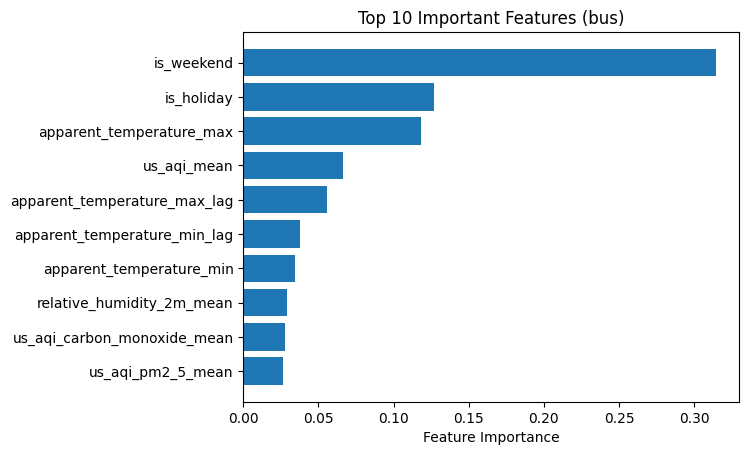

Random Forest for mode: bus
RMSE: 508.28
R²: 0.4734
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
R² scores (CV): [0.6574444931898049, 0.6741415262599498, 0.749188093118861, 0.7068020039892013, 0.7109650381968489]
RMSE scores (CV): [300.45685730744503, 281.3345616951116, 257.2761585667846, 266.4188760517739, 262.1983470421034]
Mean R²: 0.6997 ± 0.0318
Mean RMSE: 273.54 ± 15.68


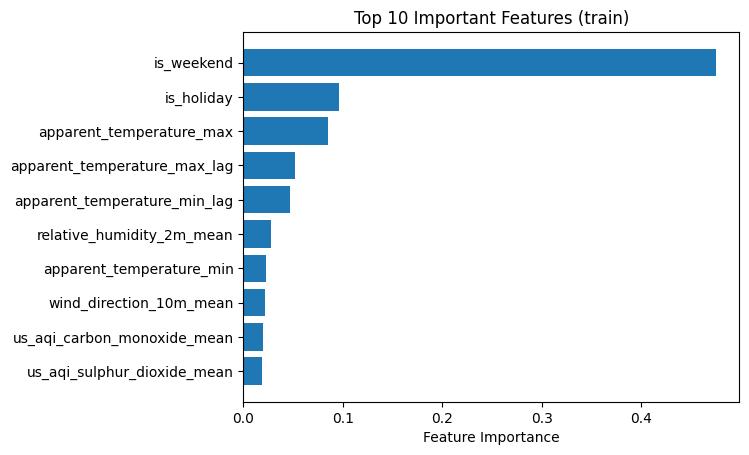

Random Forest for mode: train
RMSE: 300.18
R²: 0.6581


In [69]:
randforr(CHI_df)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 25, 'n_estimators': 200}
R² scores (CV): [0.8329524455781251, 0.8506250527951865, 0.8818716159068507, 0.8536119712321805, 0.8124054641673344]
RMSE scores (CV): [298.7263878238851, 294.22675449037297, 255.2448532412309, 280.5749350616481, 284.34752838010616]
Mean R²: 0.8463 ± 0.0231
Mean RMSE: 282.62 ± 15.17


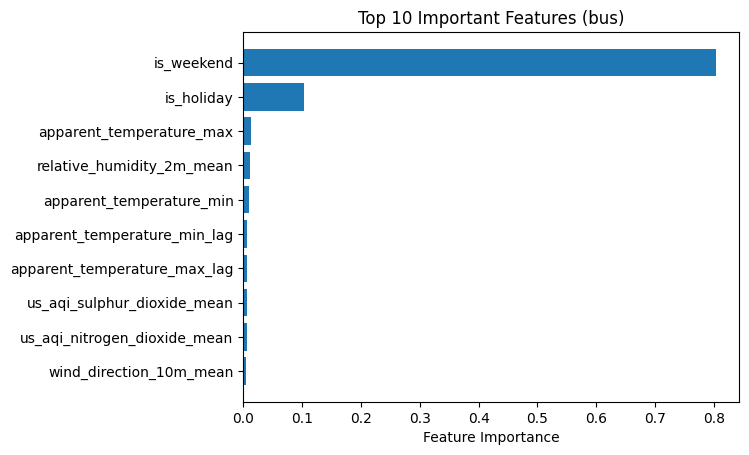

Random Forest for mode: bus
RMSE: 301.51
R²: 0.8298
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 200}
R² scores (CV): [0.8057677069341579, 0.7765534721516543, 0.8260981913696053, 0.8376632624112113, 0.8024744452269628]
RMSE scores (CV): [817.5657099108261, 904.6666799211896, 802.460560587745, 767.576304241154, 739.6229720250554]
Mean R²: 0.8097 ± 0.0211
Mean RMSE: 806.38 ± 56.15


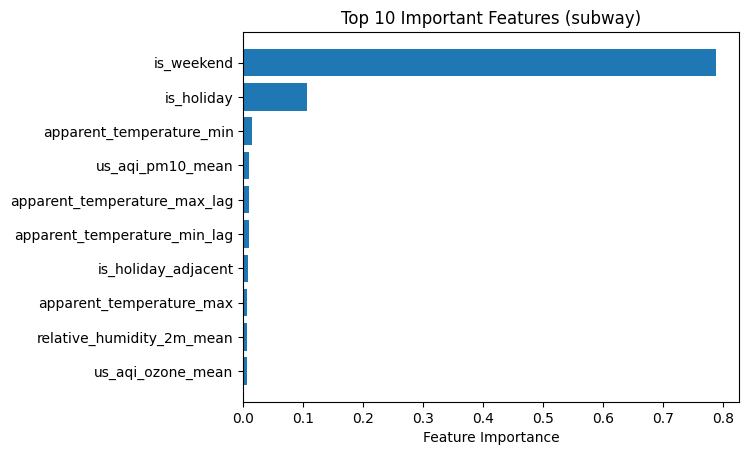

Random Forest for mode: subway
RMSE: 812.00
R²: 0.8084


In [70]:
randforr(NYC_df)

In [71]:
def randforrcomb(df, cv_folds=5):
    drop_cols = ['state', 'unit_id', 'mode']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    # Separate target and features
    y = df['daily_ridership']
    X = df.drop(columns=['daily_ridership', 'date'])

    # Grid search for best parameters
    rf = RandomForestRegressor(random_state=27, n_jobs=-1)
    param_grid = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10, 25],
        'min_samples_leaf': [1, 2, 5, 10]
    }
    grid_search = GridSearchCV(rf, param_grid, cv=cv_folds, scoring='r2', n_jobs=-1)
    grid_search.fit(X, y)
    rf = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)

    # Cross-validation scoring
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=27)
    r2_scores = []
    rmse_scores = []

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        r2_scores.append(r2_score(y_test, y_pred))
        rmse_scores.append(root_mean_squared_error(y_test, y_pred))

    print("R² scores (CV):", r2_scores)
    print("RMSE scores (CV):", rmse_scores)
    print(f"Mean R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Mean RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")

    # Final evaluation on train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    importances = rf.feature_importances_
    feat_names = X_train.columns
    sorted_idx = np.argsort(importances)[::-1]
    plt.barh(range(10), importances[sorted_idx[:10]])
    plt.yticks(range(10), feat_names[sorted_idx[:10]])
    plt.xlabel("Feature Importance")
    plt.title("Top 10 Important Features")
    plt.gca().invert_yaxis()
    plt.show()

    print(f"Random Forest Model Evaluation")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")

In [72]:
print(CHI_df.shape)
print(NYC_df.shape)
df_all = pd.concat([CHI_df, NYC_df], ignore_index=True)
print(df_all.shape)

(1460, 25)
(1462, 25)
(2922, 25)


In [73]:
CHI_df = CHI_df.drop(columns='mode', errors='ignore')
NYC_df = NYC_df.drop(columns='mode', errors='ignore')

concat_df = pd.concat([CHI_df, NYC_df], ignore_index=True)

comb_df = concat_df.groupby('date', as_index=False).agg('first')  
comb_df['daily_ridership'] = concat_df.groupby('date')['daily_ridership'].sum().values

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 25, 'n_estimators': 50}
R² scores (CV): [0.7974775342851673, 0.7831365669304728, 0.8140684871912918, 0.7911169267437612, 0.7565080919942119]
RMSE scores (CV): [1577.0370843974454, 1700.249787049133, 1619.8261175635694, 1665.2261971921084, 1544.2440243496146]
Mean R²: 0.7885 ± 0.0189
Mean RMSE: 1621.32 ± 56.68


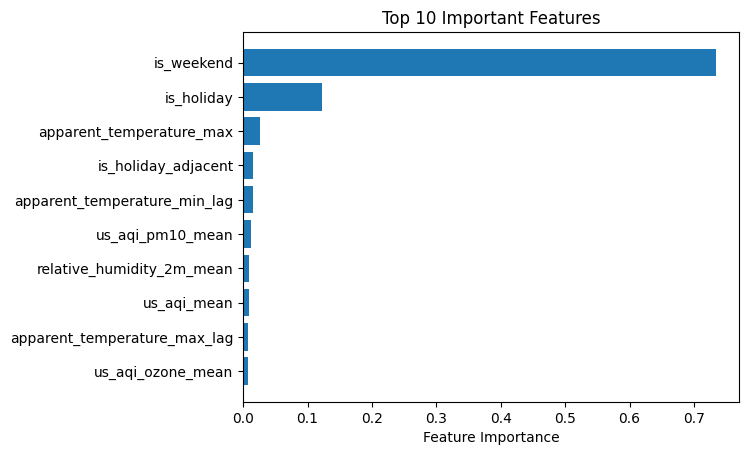

Random Forest Model Evaluation
RMSE: 1582.14
R²: 0.7962


In [81]:
randforrcomb(comb_df)